#### Background
The study will adopt a Survival Analysis approach to determine a default/deliquent event and time in months to the event.

In [1]:
#pip install -q swifter

In [2]:
# Import the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import f_classif
from scipy.stats import chi2_contingency
import swifter
import logging
import joblib

In [3]:
main = pd.read_csv('./loan_data.csv')

In [4]:
main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100514 entries, 0 to 100513
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan ID                       100000 non-null  object 
 1   Customer ID                   100000 non-null  object 
 2   Loan Status                   100000 non-null  object 
 3   Current Loan Amount           100000 non-null  float64
 4   Term                          100000 non-null  object 
 5   Credit Score                  80846 non-null   float64
 6   Annual Income                 80846 non-null   float64
 7   Years in current job          95778 non-null   object 
 8   Home Ownership                100000 non-null  object 
 9   Purpose                       100000 non-null  object 
 10  Monthly Debt                  100000 non-null  float64
 11  Years of Credit History       100000 non-null  float64
 12  Months since last delinquent  46859 non-null

In [5]:
#Renaming the columns
main.rename(columns = {'Loan Status':'loan_status', 'Current Loan Amount':'curr_loan_amnt', 'Term':'term', 'Credit Score':'credit_score', 'Annual Income':'ann_inc', 'Years in current job':'emp_len', 'Home Ownership':'home_own', 'Purpose':'purpose', 'Monthly Debt':'mthly_debt', 'Years of Credit History': 'yrs_of_crt_hist', 'Months since last delinquent':'mths_since_last_delinq', 'Number of Open Accounts':'num_of_open_acc', 'Number of Credit Problems':'num_of_cred_prob', 'Current Credit Balance':'curr_cred_bal', 'Maximum Open Credit':'max_opem_cred', 'Bankruptcies':'bankrupts', 'Tax Liens':'tax_liens'}, inplace = True)

In [6]:
pd.options.display.max_columns = None
main.head()

,Loan ID,Customer ID,loan_status,curr_loan_amnt,term,credit_score,ann_inc,emp_len,home_own,purpose,mthly_debt,yrs_of_crt_hist,mths_since_last_delinq,num_of_open_acc,num_of_cred_prob,curr_cred_bal,max_opem_cred,bankrupts,tax_liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6.0,1.0,228190.0,416746.0,1.0,0.0
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35.0,0.0,229976.0,850784.0,0.0,0.0
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0
4,d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220.0,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NaN,15.0,0.0,253460.0,427174.0,0.0,0.0


In [7]:
na_values = main.isnull().mean()
na_values[na_values>0.5]

mths_since_last_delinq    0.533806
dtype: float64

In [8]:
main.dropna(axis = 0, inplace = True)

In [9]:
main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36423 entries, 2 to 99997
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Loan ID                 36423 non-null  object 
 1   Customer ID             36423 non-null  object 
 2   loan_status             36423 non-null  object 
 3   curr_loan_amnt          36423 non-null  float64
 4   term                    36423 non-null  object 
 5   credit_score            36423 non-null  float64
 6   ann_inc                 36423 non-null  float64
 7   emp_len                 36423 non-null  object 
 8   home_own                36423 non-null  object 
 9   purpose                 36423 non-null  object 
 10  mthly_debt              36423 non-null  float64
 11  yrs_of_crt_hist         36423 non-null  float64
 12  mths_since_last_delinq  36423 non-null  float64
 13  num_of_open_acc         36423 non-null  float64
 14  num_of_cred_prob        36423 non-null

In [10]:
main = main.drop(columns=['Loan ID', 'Customer ID'])

In [11]:
main = main.drop_duplicates()

In [12]:
main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31254 entries, 2 to 99997
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   loan_status             31254 non-null  object 
 1   curr_loan_amnt          31254 non-null  float64
 2   term                    31254 non-null  object 
 3   credit_score            31254 non-null  float64
 4   ann_inc                 31254 non-null  float64
 5   emp_len                 31254 non-null  object 
 6   home_own                31254 non-null  object 
 7   purpose                 31254 non-null  object 
 8   mthly_debt              31254 non-null  float64
 9   yrs_of_crt_hist         31254 non-null  float64
 10  mths_since_last_delinq  31254 non-null  float64
 11  num_of_open_acc         31254 non-null  float64
 12  num_of_cred_prob        31254 non-null  float64
 13  curr_cred_bal           31254 non-null  float64
 14  max_opem_cred           31254 non-null

In [13]:
# explore the unique values in loan_status column
main['loan_status'].value_counts(normalize=True)


Fully Paid     0.761599
Charged Off    0.238401
Name: loan_status, dtype: float64

In [14]:
main['loan_status'] = np.where(main.loc[:, 'loan_status'].isin(['Charged Off']), 0, 1)


In [15]:
X = main.drop('loan_status', axis=1)
y = main['loan_status']

In [16]:
def emp_prep(val):
     if pd.isnull(val):
         return 0
     
     emp = str(val).replace('\+ years', '')
     emp = emp.replace('< 1 year', '0')
     emp = emp.replace(' years', '')
     emp = emp.replace(' year', '')
     emp = emp.replace('+', '')
     return float(emp)


In [17]:
X['emp_len'] = X['emp_len'].apply(emp_prep)

In [18]:
X['emp_len'].describe()

count    31254.000000
mean         6.147533
std          3.611287
min          0.000000
25%          3.000000
50%          7.000000
75%         10.000000
max         10.000000
Name: emp_len, dtype: float64

In [19]:
# first divide training data into categorical and numerical subsets
X_cat = X.select_dtypes(include='object').copy()
X_num = X.select_dtypes(include='number').copy()

In [20]:
# define an empty dictionary to store chi-squared test results
chi2_check = {}

# loop over each column in the training set to calculate chi-statistic with the target variable
for column in X_cat:
    chi, p, dof, ex = chi2_contingency(
        pd.crosstab(y, X_cat[column]))
    chi2_check.setdefault('Feature', []).append(column)
    chi2_check.setdefault('p-value', []).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data=chi2_check)
chi2_result.sort_values(by=['p-value'], ascending=True,
                        ignore_index=True, inplace=True)
chi2_result

,Feature,p-value
0,term,0.0
1,home_own,0.0
2,purpose,0.0


We'll keep all the 3 categorical features

In [21]:
# since f_class_if does not accept missing values, we will do a very crude imputation of missing values
X_num.fillna(X_num.mean(), inplace=True)
# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(X_num, y)
# convert to a DF
ANOVA_F_table = pd.DataFrame(data={'Numerical_Feature': X_num.columns.values,
                             'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(
    by=['F-Score'], ascending=False, ignore_index=True, inplace=True)
ANOVA_F_table

,Numerical_Feature,F-Score,p values
0,credit_score,8322.515467,0.000000
1,curr_loan_amnt,1935.300040,0.000000
2,ann_inc,126.448588,0.000000
3,yrs_of_crt_hist,43.235060,0.000000
4,num_of_open_acc,21.072965,0.000004
5,emp_len,12.963006,0.000318
6,mthly_debt,12.864969,0.000335
7,mths_since_last_delinq,12.723724,0.000362
8,tax_liens,6.358534,0.011687
9,curr_cred_bal,3.267604,0.070670


<AxesSubplot:>

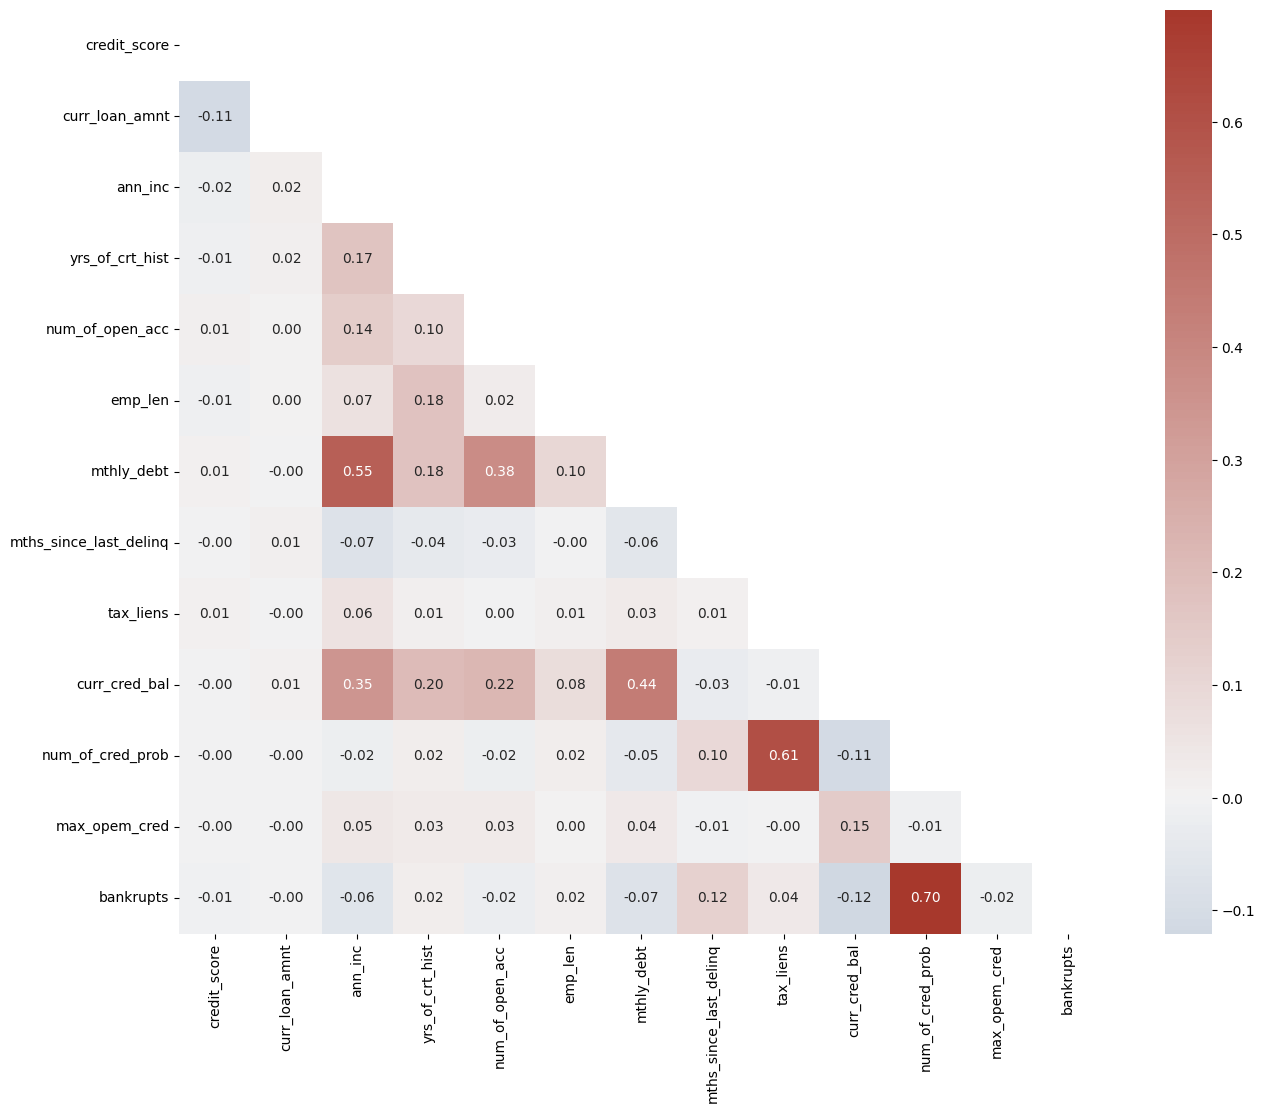

In [22]:
# save the top 20 numerical features in a list
top_num_features = ANOVA_F_table.iloc[:, 0].to_list()
# calculate pair-wise correlations between them
corrmat = X_num[top_num_features].corr()
plt.figure(figsize=(16, 12))
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)
mask = np.triu(np.ones_like(corrmat, dtype=bool))
sns.heatmap(corrmat, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap)

In [23]:
X.describe()

,curr_loan_amnt,credit_score,ann_inc,emp_len,mthly_debt,yrs_of_crt_hist,mths_since_last_delinq,num_of_open_acc,num_of_cred_prob,curr_cred_bal,max_opem_cred,bankrupts,tax_liens
count,3.125400e+04,31254.000000,3.125400e+04,31254.000000,31254.000000,31254.000000,31254.000000,31254.000000,31254.000000,3.125400e+04,3.125400e+04,31254.000000,31254.000000
mean,1.599975e+07,1114.460101,1.460592e+06,6.147533,19220.663249,19.102169,34.942151,11.508831,0.183720,2.641227e+05,6.800816e+05,0.113106,0.038491
std,3.630042e+07,1544.752600,9.378285e+05,3.611287,12098.536332,6.670789,21.923863,4.991969,0.526855,3.197944e+05,6.054028e+06,0.357000,0.301167
min,2.145000e+04,585.000000,1.112450e+05,0.000000,0.000000,3.800000,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.945735e+05,705.000000,9.300025e+05,3.000000,11086.927500,14.500000,16.000000,8.000000,0.000000,1.016738e+05,2.497880e+05,0.000000,0.000000
50%,3.270300e+05,725.000000,1.258142e+06,7.000000,17061.240000,17.800000,32.000000,11.000000,0.000000,1.873590e+05,4.252930e+05,0.000000,0.000000
75%,5.590200e+05,740.000000,1.740310e+06,10.000000,24703.800000,22.500000,51.000000,14.000000,0.000000,3.284482e+05,7.106110e+05,0.000000,0.000000
max,1.000000e+08,7510.000000,3.083900e+07,10.000000,229057.920000,70.500000,176.000000,48.000000,15.000000,7.350321e+06,7.982554e+08,7.000000,15.000000


From the above exploration I will stick with using all the features

### Saving

In [24]:
main.to_csv('./X_pro.csv', index=False)